In [59]:
# Import required packages
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm
import pandas as pd
import time
import os 

start_time = time.time()

# Fix random seeds for reproducibility
np.random.seed(1234)
tf.set_random_seed(1234)

In [60]:
######################################################################################
# A basic PINN Tensorflow class for solving a continuous-time in-homogeneous Markov chains
class IHMC:
    # Initialize the class
    def __init__(self, X_u, Y_u, X_r, layers):
        
        ######################################################################################
        # Normalization constants
        self.mu_x, self.sigma_x = X_r.mean(0), X_r.std(0)
        
        # Normalize inputs
        X_u = (X_u - self.mu_x)/self.sigma_x
        X_r = (X_r - self.mu_x)/self.sigma_x
        self.N_u = X_u.shape[0]
        self.N_r = X_r.shape[0]

        # Store data                
        self.X_u = X_u
        self.Y_u = Y_u
        self.X_r = X_r
        
        ######################################################################################
        #self.f = f_tf
        self.layers = layers
        # Initialize network weights and biases        
        self.weights, self.biases = self.initialize_NN(layers)
        
        ######################################################################################
        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
        # Define placeholders and computational graph
        self.Xu_tf = tf.placeholder(tf.float32, shape=(None, self.X_u.shape[1]))
        self.Yu_tf = tf.placeholder(tf.float32, shape=(None, self.Y_u.shape[1]))
        self.Xr_tf = tf.placeholder(tf.float32, shape=(None, self.X_r.shape[1]))
        
        # Evaluate prediction
        self.u_pred = self.net_u(self.Xu_tf)
        self.r_pred, self.loss_1, self.loss_2, self.loss_3 = self.get_r(self.Xr_tf)        
        
        # Evaluate loss
        self.loss_u = tf.reduce_mean(tf.square(self.Yu_tf[:,0:1] - self.u_pred[:,0:1]))
        self.loss_r = self.r_pred
        
         # Combine Loss Equal-Weighted
        self.loss = self.loss_u + self.loss_r
     
        # Define optimizer with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        #self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
        #                                           1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        #self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)
        
        self.learning_rate = 1e-3
        self.optimizer = tf.train.AdamOptimizer()
        self.train_op = self.optimizer.minimize(self.loss)        
        # Define optimizer (use L-BFGS for better accuracy)       
        '''self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(np.float32).eps})
        self.optimizer = tf.train.AdamOptimizer()
        '''
        
        # Logger
        self.loss_u_log = []
        self.loss_r_log = []
        self.loss_1_log = []
        self.loss_2_log = []
        self.loss_3_log = []
        self.saver = tf.train.Saver()
        
        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    
    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):      
        # Xavier initialization
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
            return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev, dtype=tf.float32)   
        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
         
    # Evaluates the forward pass
    def forward_pass(self, H):
        num_layers = len(self.layers)
        for l in range(0,num_layers-2):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = self.weights[-1]
        b = self.biases[-1]
        H = tf.nn.softmax(tf.add(tf.matmul(H, W), b)) ##TZ  - use softmax in the last layer
        return H
    
    # Forward pass for u
    def net_u(self, x):
        u = self.forward_pass(x)
        return u
    
    # Forward pass for f
    def get_r(self, x):
        u = self.net_u(x)
        u1 = u[:,0:1]
        u2 = u[:,1:2]
        u3 = u[:,2:3]
        
        u_x_1 = tf.gradients(u1, x)[0]/self.sigma_x
        u_x_2 = tf.gradients(u2, x)[0]/self.sigma_x
        u_x_3 = tf.gradients(u3, x)[0]/self.sigma_x

        #calculate residuals
        #xx = x*self.sigma_x + self.mu_x
        residual_1 = u_x_1-(-1.286e-4*u1)
        residual_2 = u_x_2-(5.6e-5*u1-1.006e-4*u2)
        residual_3 = u_x_3-(7.26e-5*u1+1.006e-4*u2)     
        
        loss_1 = tf.reduce_mean(tf.square(residual_1))
        loss_2 = tf.reduce_mean(tf.square(residual_2))
        loss_3 = tf.reduce_mean(tf.square(residual_3))

        #total residual
        residual = loss_1 + loss_2 + loss_3 
        
        return residual,loss_1,loss_2,loss_3

    # Callback to print the loss at every optimization step
    def callback(self, loss_u, loss_r):
        print('Loss_u: %.3e, Loss_r: %.3e' % 
                      (loss_u, loss_r))

    # Trains the model by minimizing the MSE loss using Adam
    def train(self, nIter = 10000): 
        
        # Define a dictionary for associating placeholders with data
        tf_dict = {self.Xu_tf: self.X_u, self.Yu_tf: self.Y_u,
                   self.Xr_tf: self.X_r}

        start_time = timeit.default_timer()
        
        for it in tqdm(range(nIter)):                 
            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)
            
            # Print
            if it % 1000 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_u_value = self.sess.run(self.loss_u, tf_dict)
                loss_r_value = self.sess.run(self.loss_r, tf_dict)
                loss_1_value = self.sess.run(self.loss_1, tf_dict)
                loss_2_value = self.sess.run(self.loss_2, tf_dict)
                loss_3_value = self.sess.run(self.loss_3, tf_dict)
                
                self.loss_u_log.append(loss_u_value)
                self.loss_r_log.append(loss_r_value)
                self.loss_1_log.append(loss_1_value)
                self.loss_2_log.append(loss_2_value)
                self.loss_3_log.append(loss_3_value)
                
                print('It: %d, Loss: %.3e, Loss_u: %.3e, Loss_r: %.3e, Time: %.2f' % 
                      (it, loss_value, loss_u_value, loss_r_value, elapsed))
                start_time = timeit.default_timer()
            
    # Trains the model by minimizing the MSE loss using L-BFGS
    def fine_tune(self):
        # Define a dictionary for associating placeholders with data
        tf_dict = {self.Xu_tf: self.X_u, self.Yu_tf: self.Y_u,
                   self.Xr_tf: self.X_r}

        # Call SciPy's L-BFGS otpimizer
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss_u, self.loss_r], 
                                loss_callback = self.callback)
        
    # Evaluates predictions at collocation points           
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_x)/self.sigma_x
        tf_dict = {self.Xu_tf: X_star}       
        u_star = self.sess.run(self.u_pred, tf_dict) 
        return u_star
    
    # Evaluates predictions at test points           
    def predict_r(self, X_star):     
        X_star = (X_star - self.mu_x)/self.sigma_x
        tf_dict = {self.Xr_tf: X_star}       
        r_star = self.sess.run(self.r_pred, tf_dict) 
        return r_star

In [61]:
######################################################################################
# Number of training data
N_u = 1                        # Boundary condition data on u(x)  
N_r = 5000                      # Number of collocation points for minimizing the PDE residual
lb  = np.array([0.0])         # Left boundary of the domain
ub  = np.array([60000.0])          # Right boundary of the domain

# Generate training data
x_u = np.array([[0]])  ##TZ
# x_u = np.linspace(lb, ub, N_u)     # Location of boundary points (dimension N_u x 1)
x_r = np.linspace(lb, ub, N_r)     # Location of collocation points (dimension N_r x 1)
y_u = np.array([[1,0,0]])   ##TZ                    # Solution at boundary points (dimension N_u x 1)
# y_u = u(x_u)                       # Solution at boundary points (dimension N_u x 1)

In [62]:
######################################################################################
# Test data for validating the model predictions
n_star = 5000+1
x_star = np.linspace(lb, ub, n_star)
#x_star = np.linspace(np.array([0.0]), np.array([0.5]), n_star)

In [63]:
######################################################################################
# Fully-connected neural net architecture (dimensions of each layer)
#n_layers = 1
#layers = [1,50,4]
n_layers = 2
layers = [1,50,50,3]
#n_layers = 4
#layers = [1,50,50,50,50,4]
#n_layers = 8
#layers = [1,50,50,50,50,50,50,50,50,4]
#n_layers = 16
#layers = [1,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,4]
#  Define PINN model
model = IHMC(x_u, y_u, x_r, layers)   

Device mapping: no known devices.


In [64]:
######################################################################################
# Load stored model
# model.saver.restore(model.sess, "../SavedModels/elliptic1d.ckpt")
# Train model using full batch gradient descent
n_iter = 20000
model.train(n_iter)

  0%|          | 6/20000 [00:00<33:19, 10.00it/s]  

It: 0, Loss: 6.355e-01, Loss_u: 6.355e-01, Loss_r: 6.238e-09, Time: 0.35


  5%|▌         | 1008/20000 [00:16<05:10, 61.13it/s]

It: 1000, Loss: 2.704e-05, Loss_u: 2.703e-05, Loss_r: 1.007e-08, Time: 16.10


 10%|█         | 2009/20000 [00:31<05:06, 58.63it/s]

It: 2000, Loss: 7.498e-06, Loss_u: 7.488e-06, Loss_r: 1.059e-08, Time: 14.21


 15%|█▌        | 3016/20000 [00:45<04:01, 70.34it/s]

It: 3000, Loss: 3.164e-06, Loss_u: 3.153e-06, Loss_r: 1.090e-08, Time: 14.05


 20%|██        | 4015/20000 [00:59<03:33, 74.70it/s]

It: 4000, Loss: 1.570e-06, Loss_u: 1.559e-06, Loss_r: 1.114e-08, Time: 13.94


 25%|██▌       | 5012/20000 [01:14<03:41, 67.78it/s]

It: 5000, Loss: 8.445e-07, Loss_u: 8.332e-07, Loss_r: 1.135e-08, Time: 15.34


 30%|███       | 6010/20000 [01:29<03:29, 66.77it/s]

It: 6000, Loss: 4.763e-07, Loss_u: 4.648e-07, Loss_r: 1.153e-08, Time: 14.62


 35%|███▌      | 7008/20000 [01:43<03:07, 69.21it/s]

It: 7000, Loss: 2.775e-07, Loss_u: 2.658e-07, Loss_r: 1.170e-08, Time: 14.78


 40%|████      | 8011/20000 [01:59<02:55, 68.50it/s]

It: 8000, Loss: 1.661e-07, Loss_u: 1.542e-07, Loss_r: 1.186e-08, Time: 15.16


 45%|████▌     | 9008/20000 [02:13<02:48, 65.17it/s]

It: 9000, Loss: 1.024e-07, Loss_u: 9.039e-08, Loss_r: 1.200e-08, Time: 14.64


 50%|█████     | 10012/20000 [02:28<02:24, 68.99it/s]

It: 10000, Loss: 6.549e-08, Loss_u: 5.335e-08, Loss_r: 1.215e-08, Time: 14.24


 55%|█████▌    | 11010/20000 [02:42<02:10, 68.86it/s]

It: 11000, Loss: 4.390e-08, Loss_u: 3.161e-08, Loss_r: 1.228e-08, Time: 13.98


 60%|██████    | 12014/20000 [02:56<02:03, 64.74it/s]

It: 12000, Loss: 3.127e-08, Loss_u: 1.886e-08, Loss_r: 1.241e-08, Time: 14.45


 65%|██████▌   | 13009/20000 [03:12<01:56, 59.94it/s]

It: 13000, Loss: 2.381e-08, Loss_u: 1.128e-08, Loss_r: 1.252e-08, Time: 15.58


 70%|███████   | 14010/20000 [03:27<01:29, 66.74it/s]

It: 14000, Loss: 1.941e-08, Loss_u: 6.785e-09, Loss_r: 1.262e-08, Time: 14.98


 75%|███████▌  | 15011/20000 [03:41<01:11, 70.22it/s]

It: 15000, Loss: 1.682e-08, Loss_u: 4.113e-09, Loss_r: 1.270e-08, Time: 14.31


 80%|████████  | 16009/20000 [03:57<01:15, 53.16it/s]

It: 16000, Loss: 1.528e-08, Loss_u: 2.531e-09, Loss_r: 1.275e-08, Time: 15.59


 85%|████████▌ | 17012/20000 [04:11<00:41, 71.38it/s]

It: 17000, Loss: 1.435e-08, Loss_u: 1.585e-09, Loss_r: 1.276e-08, Time: 14.51


 90%|█████████ | 18010/20000 [04:26<00:29, 68.38it/s]

It: 18000, Loss: 1.374e-08, Loss_u: 1.013e-09, Loss_r: 1.273e-08, Time: 15.02


 95%|█████████▌| 19008/20000 [04:40<00:14, 69.75it/s]

It: 19000, Loss: 1.333e-08, Loss_u: 6.878e-10, Loss_r: 1.264e-08, Time: 14.07


100%|██████████| 20000/20000 [04:55<00:00, 67.76it/s]


In [65]:
######################################################################################
# Compute prediction using the trained model
u_pred = model.predict_u(x_star)
#u_pred.shape

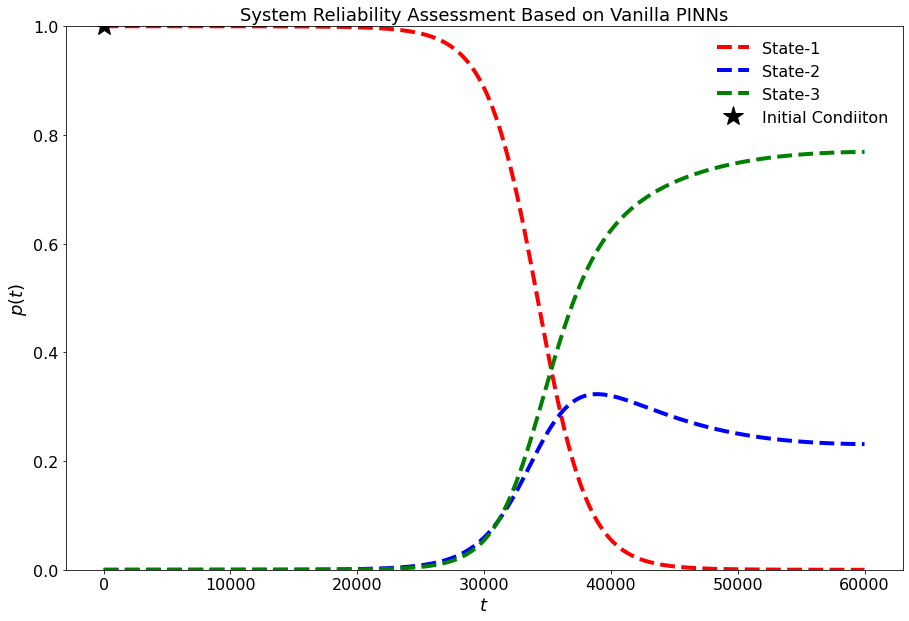

In [66]:
######################################################################################
# Plotting
plt.figure(figsize=(15,10))
plt.plot(x_star, u_pred[:,0:1], 'r--', linewidth = 4, label = "State-1")
plt.plot(x_star, u_pred[:,1:2], 'b--', linewidth = 4, label = "State-2")
plt.plot(x_star, u_pred[:,2:3], 'g--', linewidth = 4, label = "State-3", markersize=20)
plt.plot(x_u[:,0:1], y_u[:,0:1], 'k*', linewidth = 4, label = "Initial Condiiton", markersize=20)
plt.legend(frameon=False,fontsize=16)
plt.xlabel('$t$', fontsize=18)
plt.ylabel('$p(t)$', fontsize=18)
plt.title('System Reliability Assessment Based on Vanilla PINNs', fontsize=18)
#plt.yscale("log")
#plt.xlim([0,10])
plt.ylim([0,1])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [67]:
################
## output results as csv file
mc_output  = np.column_stack((np.array(x_star), u_pred))
fileName = 'mspm_pidl_' + str(N_r) + '_' + str(n_iter) + '_' + str(n_layers) + '.csv'
np.savetxt(fileName, mc_output, delimiter=",")

In [68]:
## used time
end_time = time.time() 
used_time = end_time - start_time
print("--- %s seconds ---" % (used_time))

--- 300.45692348480225 seconds ---


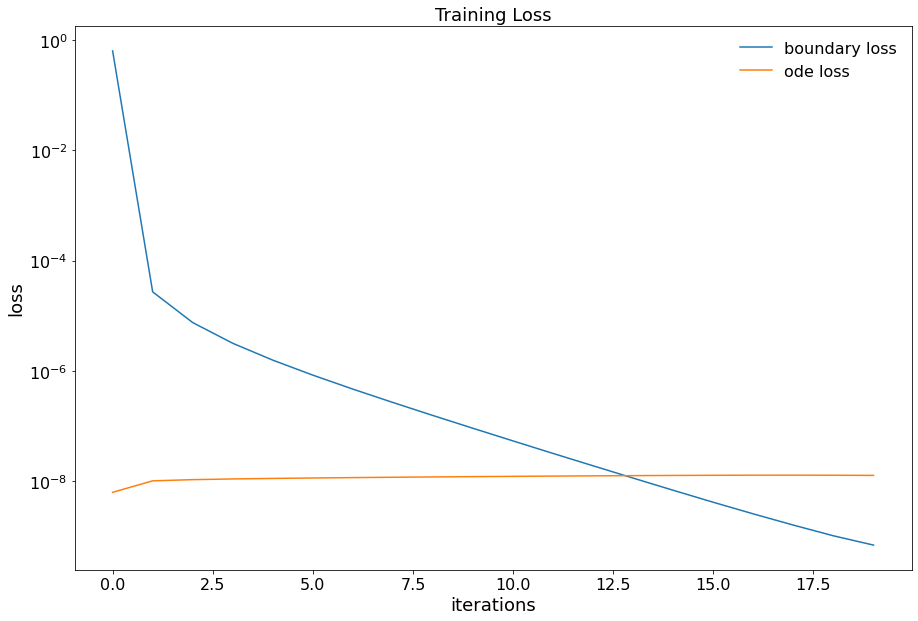

In [69]:
### plot loss function every 50 iterations
fig = plt.figure(2,figsize=(15,10))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(model.loss_u_log, label = 'boundary loss')
plt.plot(model.loss_r_log, label = 'ode loss')
plt.legend(frameon=False,fontsize=16)
plt.xlabel('iterations', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.title('Training Loss', fontsize=18)
plt.yscale("log")

plt.show()

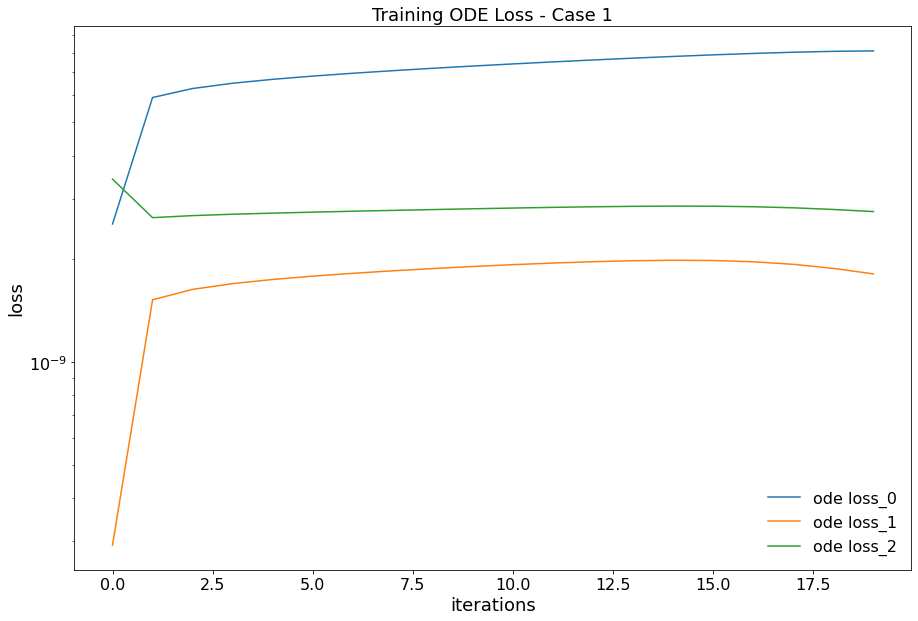

In [70]:
### plot loss function every 50 iterations
fig = plt.figure(2,figsize=(15,10))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(model.loss_1_log, label = 'ode loss_0')
plt.plot(model.loss_2_log, label = 'ode loss_1')
plt.plot(model.loss_3_log, label = 'ode loss_2')

plt.legend(frameon=False,fontsize=16)
plt.xlabel('iterations', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.title('Training ODE Loss - Case 1', fontsize=18)
plt.yscale("log")

plt.show()